Housekeeping

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline

In [18]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,endword='Tota1',
               endrow=None,exclude_list=[],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endrow==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == endword:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in exclude_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))

In [10]:
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)

In [11]:
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

In [12]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

<a id='index'></a>


## Quantile regressions for tenure

### Women

Jump to
 - [Men](#urgh)
 --------------

In [51]:
path = './results/'

file_split('descriptive_stats_tenure.log',path,startwords=['Group'],endword="Total",
           header="educ_level_hub  |      mean       p25       p50       p75")


states = ['women, kids','women, no kids','men, kids','men, no kids']
ages = ['<45','30-35']
educs = ['less_than_hs','high_school','college']
headers = ['educ_level_hub','educ_level_hub','educ_level_wife','educ_level_wife']

si, ai, ei = 0,0,0

N = len(states)*len(ages)*len(educs)

descrip_stats_45 = {}
descrip_stats_3035 = {}

buff_dict = {}

educ_i = educs[0]

for i in range(1,N):
    buff_dict[states[si]] = read_table(path+'descriptive_stats_tenure_{}.log'.format(i),keyword=headers[si],
                                       endword="Total",rescale=1,ncols=4,start=2,index_to_int=False)
    si += 1
    if i%4==0 and i%8!=0:
        descrip_stats_45[educ_i] = buff_dict.copy()
        buff_dict = {}
        si = 0
    elif i%8==0:
        descrip_stats_3035[educ_i] = buff_dict.copy()
        educ_i = educs[i//8]
        buff_dict = {}
        si = 0
        

In [55]:
path = './results/'

file_split('sqtreg_mothers.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25 = read_table(path+'sqtreg_mothers_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_50 = read_table(path+'sqtreg_mothers_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_75 = read_table(path+'sqtreg_mothers_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

descrip_stats = pd.read_stata('parents_dataset_spain.dta')


coef_50_m = tab_moms_50['Coefficient']
coef_25_m = tab_moms_25['Coefficient']
coef_75_m = tab_moms_75['Coefficient']

av_age_m_05 = descrip_stats['Age_mother'][0]
av_age_f_05 = descrip_stats['Age_father'][0]

In [57]:
tab_moms_25.head()

,Coefficient,std,t,p_stat,lower_95,upper_95q25
hub_ten_y,0.155817,0.005569,27.98,0.0,0.144903,0.166731
hub_ten_y2,-0.002294,0.000249,-9.20,0.0,-0.002783,-0.001806
age,-0.327531,0.019688,-16.64,0.0,-0.366119,-0.288943
age2,0.006733,0.000296,22.71,0.0,0.006152,0.007314
part_time,-1.557077,0.023854,-65.28,0.0,-1.603830,-1.510324


In [66]:
def predicted_ten_women(coef_series,descriptive_table,ten_range,age_at_mean=None,
                        educ=None,part_time=False,hub_educ=None):
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    av_age_da_05 = descriptive_table['Age_father'][0]
    b_ten_hub = coef_series.loc['hub_ten_y']
    b_ten2_hub = coef_series.loc['hub_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['hub_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['hub_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
    predicted_ten =  coef_series.loc['_cons'] + \
            coef_series.loc['age']*av_age_mo_05 + coef_series.loc['age2']*av_age_mo_05**2 + coef_series.loc['hub_age']*av_age_da_05 + \
            ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

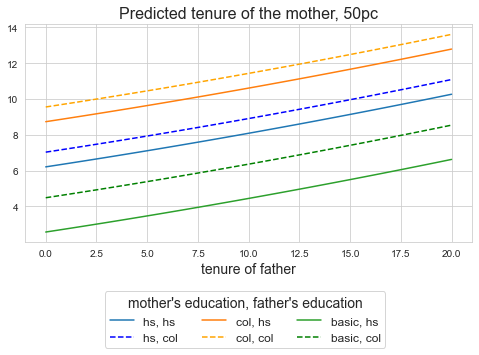

In [51]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(8,4))
plt.title('Predicted tenure of the mother, 50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,
                                       age_at_mean=descrip_stats['Age_father'][0]),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,
                                       age_at_mean=descrip_stats['Age_father'][0],hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,
                                       age_at_mean=descrip_stats['Age_father'][0],educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,
                                       age_at_mean=descrip_stats['Age_father'][0],educ='college',
         hub_educ='college'),label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')

plt.xlabel('tenure of father',fontsize=14)
plt.legend(title="mother's education, father's education",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.show()

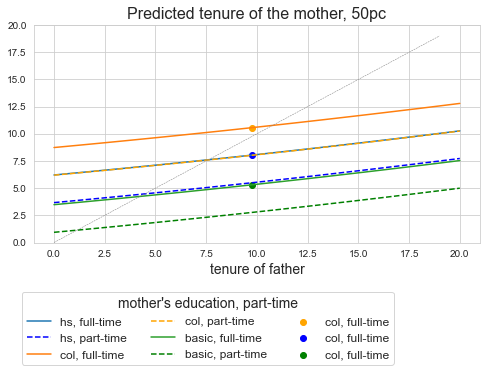

In [75]:
ten_range = np.linspace(0,20,100)
age_mean = descrip_stats['Age_father'][0]
hub_ten_mean = descrip_stats['Tenure_father'][0]/12

plt.figure(figsize=(8,4))
plt.title('Predicted tenure of the mother, 50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean),label='hs, full-time')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean,part_time=True),
         label='hs, part-time',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean,
                                       educ='college'),label='col, full-time')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean,
                                       educ='college',part_time=True),
         label='col, part-time',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean,
                                       educ='less_hs'),label='basic, full-time')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,age_at_mean=age_mean,
                                       educ='less_hs',part_time=True),
         label='basic, part-time',c='g',ls='--')

plt.scatter(hub_ten_mean,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_mean,age_at_mean=age_mean,
                                       educ='college'),label='col, full-time',c='orange')
plt.scatter(hub_ten_mean,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_mean,age_at_mean=age_mean,
                                       ),label='col, full-time',c='blue')
plt.scatter(hub_ten_mean,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_mean,age_at_mean=age_mean,
                                       educ='less_hs'),label='col, full-time',c='green')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)

plt.xlabel('tenure of father',fontsize=14)
plt.legend(title="mother's education, part-time",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,20)
plt.show()

In [64]:
tenure_tab_moms = read_table('./rawtabs_dem/tenure_mothers_w.log',ncols=7,endword='Total')
tenure_tab_dads = read_table('./rawtabs_dem/tenure_fathers_w.log',ncols=7,endword='Total')
tenure_tab_moms_0k = read_table('./rawtabs_dem/tenure_wifes_w.log',ncols=7,endword='Total')
tenure_tab_dads_0k = read_table('./rawtabs_dem/tenure_husbands_w.log',ncols=7,endword='Total')

tenure_tab_moms_45 = read_table('./rawtabs_dem/tenure_mothers_w_45.log',ncols=7,endword='Total')
tenure_tab_dads_45 = read_table('./rawtabs_dem/tenure_fathers_w_45.log',ncols=7,endword='Total')
tenure_tab_moms_0k_45 = read_table('./rawtabs_dem/tenure_wifes_w_45.log',ncols=7,endword='Total')
tenure_tab_dads_0k_45 = read_table('./rawtabs_dem/tenure_husbands_w_45.log',ncols=7,endword='Total')

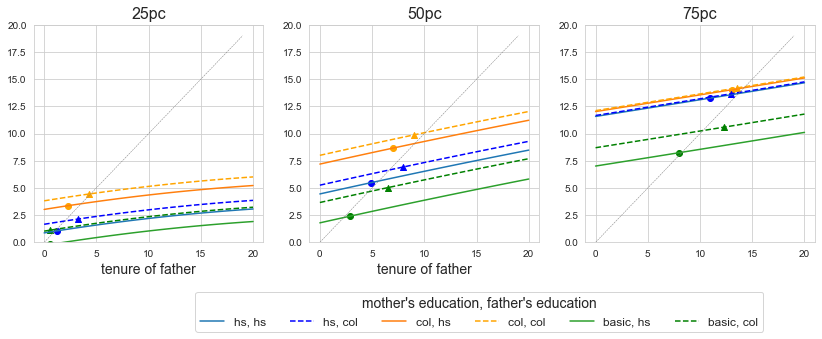

In [95]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of father',fontsize=14)

hub_ten_25 = descrip_stats_45['college']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25,educ='college',hub_educ='college'),
            c='orange',marker='^')
hub_ten_25 = descrip_stats_45['college']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25,educ='college'),c='orange')

hub_ten_25 = descrip_stats_45['high_school']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25),c='blue')
hub_ten_25 = descrip_stats_45['high_school']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25,hub_educ='college'),c='blue',marker='^')

hub_ten_25 = descrip_stats_45['less_than_hs']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25,educ='less_hs'),c='green')
ub_ten_25 = descrip_stats_45['less_than_hs']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m,descrip_stats,hub_ten_25,educ='less_hs',hub_educ='college'),
            c='green',marker='^')

plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')

hub_ten_50 = descrip_stats_45['college']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50,educ='college',hub_educ='college'),
            c='orange',marker='^')
hub_ten_50 = descrip_stats_45['college']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50,educ='college'),c='orange')

hub_ten_50 = descrip_stats_45['high_school']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50),c='blue')
hub_ten_50 = descrip_stats_45['high_school']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50,hub_educ='college'),c='blue',marker='^')

hub_ten_50 = descrip_stats_45['less_than_hs']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50,educ='less_hs'),c='green')
hub_ten_50 = descrip_stats_45['less_than_hs']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m,descrip_stats,hub_ten_50,educ='less_hs',hub_educ='college'),
            c='green',marker='^')

plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.xlabel('tenure of father',fontsize=14)
plt.legend(title="mother's education, father's education",fontsize=12,title_fontsize=14,ncol=6,
           bbox_to_anchor=(2,-0.2))
plt.ylim(0,20)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
# plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')

hub_ten_75 = descrip_stats_45['college']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,
                                       educ='college',hub_educ='college'),c='orange',marker='^')
hub_ten_75 = descrip_stats_45['college']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,
                                       educ='college'),c='orange')

hub_ten_75 = descrip_stats_45['high_school']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,
                                       ),c='blue')
hub_ten_75 = descrip_stats_45['high_school']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,hub_educ='college',
                                       ),c='blue',marker='^')

hub_ten_75 = descrip_stats_45['less_than_hs']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,
                                       educ='less_hs'),c='green')
hub_ten_75 = descrip_stats_45['less_than_hs']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m,descrip_stats,hub_ten_75,
                                       educ='less_hs',hub_educ='college'),c='green',marker='^')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)

plt.ylim(0,20)

# plt.savefig('./plots_tenure/qregs_spa_all_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [96]:
path = './results/'

file_split('sqtreg_mothers_45.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'sqtreg_mothers_45_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_50 = read_table(path+'sqtreg_mothers_45_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_75 = read_table(path+'sqtreg_mothers_45_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

descrip_stats = pd.read_stata('parents_dataset_spain.dta')


coef_50_m_45 = tab_moms_45_50['Coefficient']
coef_25_m_45 = tab_moms_45_25['Coefficient']
coef_75_m_45 = tab_moms_45_75['Coefficient']

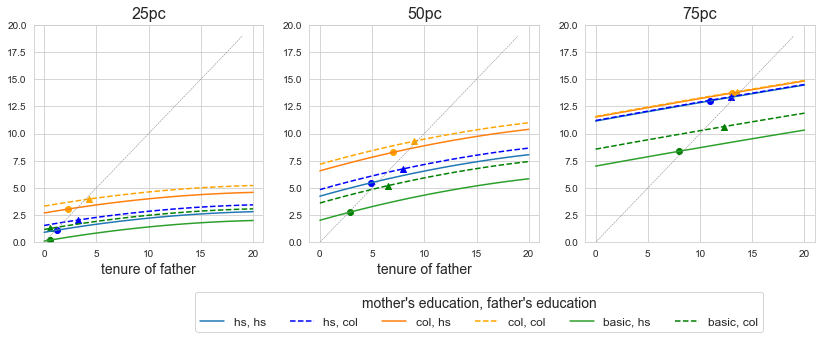

In [97]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of father',fontsize=14)

hub_ten_25 = descrip_stats_45['college']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25,educ='college',hub_educ='college'),
            c='orange',marker='^')
hub_ten_25 = descrip_stats_45['college']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25,educ='college'),c='orange')

hub_ten_25 = descrip_stats_45['high_school']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25),c='blue')
hub_ten_25 = descrip_stats_45['high_school']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25,hub_educ='college'),c='blue',marker='^')

hub_ten_25 = descrip_stats_45['less_than_hs']['men, kids']['p25']['high_school']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25,educ='less_hs'),c='green')
ub_ten_25 = descrip_stats_45['less_than_hs']['men, kids']['p25']['college']
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,hub_ten_25,educ='less_hs',hub_educ='college'),
            c='green',marker='^')

plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')

hub_ten_50 = descrip_stats_45['college']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50,educ='college',hub_educ='college'),
            c='orange',marker='^')
hub_ten_50 = descrip_stats_45['college']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50,educ='college'),c='orange')

hub_ten_50 = descrip_stats_45['high_school']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50),c='blue')
hub_ten_50 = descrip_stats_45['high_school']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50,hub_educ='college'),c='blue',marker='^')

hub_ten_50 = descrip_stats_45['less_than_hs']['men, kids']['p50']['high_school']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50,educ='less_hs'),c='green')
hub_ten_50 = descrip_stats_45['less_than_hs']['men, kids']['p50']['college']
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,hub_ten_50,educ='less_hs',hub_educ='college'),
            c='green',marker='^')

plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.xlabel('tenure of father',fontsize=14)
plt.legend(title="mother's education, father's education",fontsize=12,title_fontsize=14,ncol=6,
           bbox_to_anchor=(2,-0.2))
plt.ylim(0,20)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
# plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')

hub_ten_75 = descrip_stats_45['college']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,
                                       educ='college',hub_educ='college'),c='orange',marker='^')
hub_ten_75 = descrip_stats_45['college']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,
                                       educ='college'),c='orange')

hub_ten_75 = descrip_stats_45['high_school']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,
                                       ),c='blue')
hub_ten_75 = descrip_stats_45['high_school']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,hub_educ='college',
                                       ),c='blue',marker='^')

hub_ten_75 = descrip_stats_45['less_than_hs']['men, kids']['p75']['high_school']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,
                                       educ='less_hs'),c='green')
hub_ten_75 = descrip_stats_45['less_than_hs']['men, kids']['p75']['college']
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,hub_ten_75,
                                       educ='less_hs',hub_educ='college'),c='green',marker='^')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)

plt.ylim(0,20)

plt.savefig('./plots_tenure/qregs_spa_all_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [28]:
path = './results/'

file_split('sqtreg_mothers_0k_45.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'sqtreg_mothers_0k_45_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_50_0k = read_table(path+'sqtreg_mothers_0k_45_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_moms_45_75_0k = read_table(path+'sqtreg_mothers_0k_45_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_m_45_0k = tab_moms_45_50_0k['Coefficient']
coef_25_m_45_0k = tab_moms_45_25_0k['Coefficient']
coef_75_m_45_0k = tab_moms_45_75_0k['Coefficient']

In [137]:
hub_ten_25,hub_ten_50,hub_ten_75 = tenure_tab_dads_0k_45.loc[130]['p25']/12,tenure_tab_dads_0k_45.loc[130]['p50']/12,tenure_tab_dads_0k_45.loc[130]['p75']/12
wife_ten_25,wife_ten_50,wife_ten_75 = tenure_tab_moms_0k_45.loc[130]['p25']/12,tenure_tab_moms_0k_45.loc[130]['p50']/12,tenure_tab_moms_0k_45.loc[130]['p75']/12
dad_ten_25,dad_ten_50,dad_ten_75 = tenure_tab_dads_45.loc[130]['p25']/12,tenure_tab_dads_45.loc[130]['p50']/12,tenure_tab_dads_45.loc[130]['p75']/12
mom_ten_25,mom_ten_50,mom_ten_75 = tenure_tab_moms_45.loc[130]['p25']/12,tenure_tab_moms_45.loc[130]['p50']/12,tenure_tab_moms_45.loc[130]['p75']/12

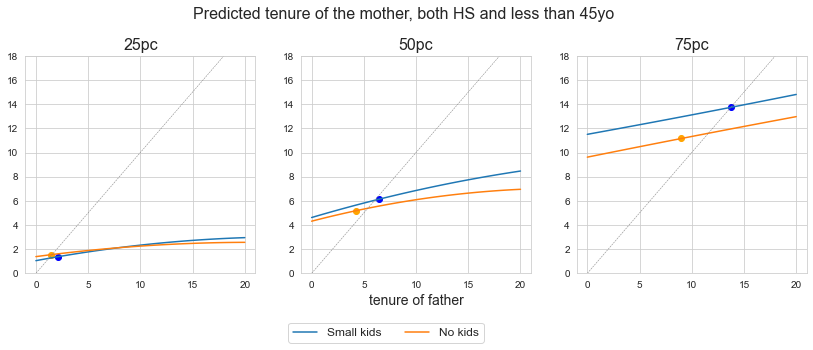

In [124]:
ten_range = np.linspace(0,20,100)


plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both HS and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range),label='No kids')

plt.scatter(dad_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,dad_ten_25),c='blue')
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45_0k,descrip_stats,hub_ten_25),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
# plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,18)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))

plt.scatter(dad_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,dad_ten_50),c='blue')
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45_0k,descrip_stats,hub_ten_50),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,18)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range),label='No kids')

plt.scatter(dad_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,dad_ten_75),c='blue')
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45_0k,descrip_stats,hub_ten_75),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,18)

plt.savefig('./plots_tenure/qregs_spa_HS_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

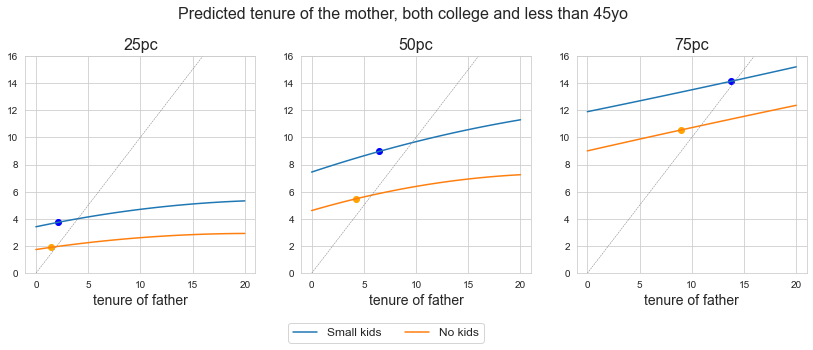

In [127]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')

plt.scatter(dad_ten_25,predicted_ten_women(coef_25_m_45,descrip_stats,dad_ten_25,educ='college',hub_educ='college'),c='blue')
plt.scatter(hub_ten_25,predicted_ten_women(coef_25_m_45_0k,descrip_stats,hub_ten_25,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))

plt.scatter(dad_ten_50,predicted_ten_women(coef_50_m_45,descrip_stats,dad_ten_50,educ='college',hub_educ='college'),c='blue')
plt.scatter(hub_ten_50,predicted_ten_women(coef_50_m_45_0k,descrip_stats,hub_ten_50,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')

plt.scatter(dad_ten_75,predicted_ten_women(coef_75_m_45,descrip_stats,dad_ten_75,educ='college',hub_educ='college'),c='blue')
plt.scatter(hub_ten_75,predicted_ten_women(coef_75_m_45_0k,descrip_stats,hub_ten_75,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

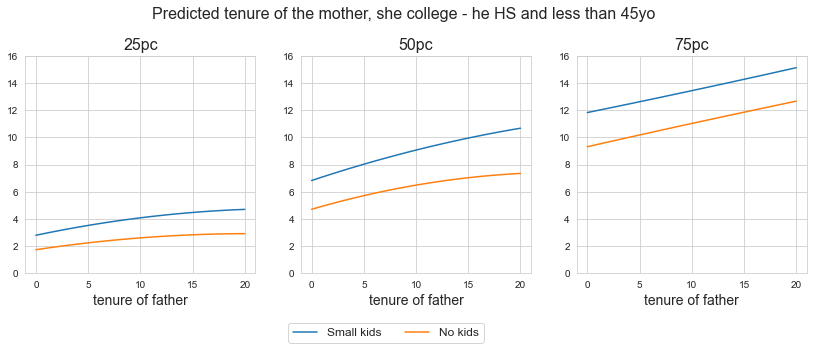

In [33]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the mother, she college - he HS and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_25_m_45,descrip_stats,ten_range,educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_25_m_45_0k,descrip_stats,ten_range,educ='college'),label='No kids')
plt.xlabel('tenure of father',fontsize=14)
plt.ylim(0,16)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_50_m_45,descrip_stats,ten_range,educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_50_m_45_0k,descrip_stats,ten_range,educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_women(coef_75_m_45,descrip_stats,ten_range,educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_women(coef_75_m_45_0k,descrip_stats,ten_range,educ='college'),label='No kids')
plt.ylim(0,16)
plt.xlabel('tenure of father',fontsize=14)


plt.show()

In [128]:
sd_50_m_45_0k = tab_moms_45_50_0k['std']
sd_50_m_45 = tab_moms_45_50['std']
sd_50_m = tab_moms_50['std']

sd_25_m_45_0k = tab_moms_45_25_0k['std']
sd_25_m_45 = tab_moms_45_25['std']
sd_25_m = tab_moms_25['std']

sd_75_m_45_0k = tab_moms_45_75_0k['std']
sd_75_m_45 = tab_moms_45_75['std']
sd_75_m = tab_moms_75['std']

In [38]:
bnames = coef_50_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['All, With kids','Less than 45, With kids','Less than 45, No kids']

data_all = np.empty(N*2)
data_0k_45 = np.empty(N*2)
data_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_0k_45[i] = coef_50_m_45_0k.loc[name]
    data_45[i] = coef_50_m_45.loc[name]
    data_all[i] = coef_50_m.loc[name]
    i+=1
    data_0k_45[i] = sd_50_m_45_0k.loc[name]
    data_45[i] = sd_50_m_45.loc[name]
    data_all[i] = sd_50_m.loc[name]
    i+=1
    
coef_table_export = pd.DataFrame(np.vstack((data_all,data_45,data_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export.iloc[i,0]='('+str(coef_table_export.iloc[i,0])+')'
    coef_table_export.iloc[i,1]='('+str(coef_table_export.iloc[i,1])+')'
    coef_table_export.iloc[i,2]='('+str(coef_table_export.iloc[i,2])+')'

In [39]:
print(coef_table_export.to_latex())

\begin{tabular}{llll}
\toprule
{} & All, With kids & Less than 45, With kids & Less than 45, No kids \\
\midrule
husband tenure         &          0.173 &                   0.255 &                 0.224 \\
                       &        (0.005) &                 (0.006) &               (0.007) \\
husband tenure 2       &          0.002 &                  -0.003 &                -0.005 \\
                       &          (0.0) &                   (0.0) &                 (0.0) \\
age                    &          0.412 &                   0.338 &                 0.256 \\
                       &        (0.004) &                 (0.005) &               (0.003) \\
part-time              &         -2.541 &                  -1.869 &                 -1.96 \\
                       &        (0.033) &                 (0.039) &               (0.026) \\
college                &          2.524 &                   2.211 &                 0.396 \\
                       &        (0.035) &         

In [40]:
bnames = coef_25_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['All, With kids','Less than 45, With kids','Less than 45, No kids']

data_25_all = np.empty(N*2)
data_25_0k_45 = np.empty(N*2)
data_25_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_25_0k_45[i] = coef_25_m_45_0k.loc[name]
    data_25_45[i] = coef_25_m_45.loc[name]
    data_25_all[i] = coef_25_m.loc[name]
    i+=1
    data_25_0k_45[i] = sd_25_m_45_0k.loc[name]
    data_25_45[i] = sd_25_m_45.loc[name]
    data_25_all[i] = sd_25_m.loc[name]
    i+=1
    
coef_table_export_25 = pd.DataFrame(np.vstack((data_25_all,data_25_45,data_25_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export_25.iloc[i,0]='('+str(coef_table_export_25.iloc[i,0])+')'
    coef_table_export_25.iloc[i,1]='('+str(coef_table_export_25.iloc[i,1])+')'
    coef_table_export_25.iloc[i,2]='('+str(coef_table_export_25.iloc[i,2])+')'

In [41]:
print(coef_table_export_25.to_latex())

\begin{tabular}{llll}
\toprule
{} & All, With kids & Less than 45, With kids & Less than 45, No kids \\
\midrule
husband tenure         &          0.142 &                   0.162 &                 0.115 \\
                       &        (0.005) &                 (0.005) &               (0.004) \\
husband tenure 2       &         -0.002 &                  -0.003 &                -0.003 \\
                       &          (0.0) &                   (0.0) &                 (0.0) \\
age                    &          0.146 &                   0.117 &                 0.093 \\
                       &        (0.003) &                 (0.003) &               (0.002) \\
part-time              &         -1.608 &                  -1.175 &                -1.014 \\
                       &        (0.023) &                 (0.024) &               (0.018) \\
college                &          2.097 &                   1.751 &                 0.355 \\
                       &        (0.025) &         

In [42]:
bnames = coef_75_m_45.index[:10]
N = bnames.size
pretty_names = ['husband tenure','husband tenure 2','age','part-time','college','less than HS',
               "husband's age","husband is SE","husband's college","husband's less than HS"]
rownames = list(itertools.chain.from_iterable(zip(pretty_names,['']*N)))
colnames = ['All, With kids','Less than 45, With kids','Less than 45, No kids']

data_75_all = np.empty(N*2)
data_75_0k_45 = np.empty(N*2)
data_75_45 = np.empty(N*2)

i = 0
for name in bnames:

    data_75_0k_45[i] = coef_75_m_45_0k.loc[name]
    data_75_45[i] = coef_75_m_45.loc[name]
    data_75_all[i] = coef_75_m.loc[name]
    i+=1
    data_75_0k_45[i] = sd_75_m_45_0k.loc[name]
    data_75_45[i] = sd_75_m_45.loc[name]
    data_75_all[i] = sd_75_m.loc[name]
    i+=1
    
coef_table_export_75 = pd.DataFrame(np.vstack((data_75_all,data_75_45,data_75_0k_45)),columns=rownames,
                                 index=colnames).T.round(3)

for i in range(1,20,2):
    coef_table_export_75.iloc[i,0]='('+str(coef_table_export_75.iloc[i,0])+')'
    coef_table_export_75.iloc[i,1]='('+str(coef_table_export_75.iloc[i,1])+')'
    coef_table_export_75.iloc[i,2]='('+str(coef_table_export_75.iloc[i,2])+')'

In [43]:
print(coef_table_export_75.to_latex())

\begin{tabular}{llll}
\toprule
{} & All, With kids & Less than 45, With kids & Less than 45, No kids \\
\midrule
husband tenure         &          0.109 &                   0.157 &                 0.175 \\
                       &        (0.006) &                 (0.006) &               (0.009) \\
husband tenure 2       &          0.002 &                       0 &                    -0 \\
                       &          (0.0) &                   (0.0) &                 (0.0) \\
age                    &           0.63 &                   0.578 &                 0.476 \\
                       &        (0.004) &                 (0.004) &               (0.005) \\
part-time              &         -1.884 &                  -1.418 &                -2.258 \\
                       &        (0.029) &                 (0.029) &               (0.045) \\
college                &          0.327 &                   0.324 &                -0.303 \\
                       &        (0.029) &         

In [161]:
import itertools

In [211]:
coef_table_export.to_latex?

In [129]:
print(tab_moms_45_25_0k.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &   std &       t &  p\_stat &  lower\_95 &  upper\_95q25 \\
\midrule
hub\_ten\_y   &        0.077 & 0.003 &  23.310 &   0.000 &     0.071 &        0.084 \\
hub\_ten\_y2  &       -0.002 & 0.000 & -12.510 &   0.000 &    -0.002 &       -0.002 \\
edad5       &        0.068 & 0.002 &  28.530 &   0.000 &     0.063 &        0.072 \\
pc\_dummy    &        2.285 & 0.016 & 138.620 &   0.000 &     2.252 &        2.317 \\
part\_time   &       -0.517 & 0.016 & -32.930 &   0.000 &    -0.547 &       -0.486 \\
college     &        0.271 & 0.026 &  10.440 &   0.000 &     0.220 &        0.322 \\
less\_hs     &       -0.223 & 0.039 &  -5.770 &   0.000 &    -0.299 &       -0.147 \\
hub\_age     &       -0.003 & 0.002 &  -1.640 &   0.102 &    -0.008 &        0.001 \\
hub\_se      &       -0.077 & 0.025 &  -3.080 &   0.002 &    -0.126 &       -0.028 \\
hub\_college &       -0.029 & 0.017 &  -1.640 &   0.101 &    -0.063 &        0.006 \\
hub\_less\_hs &   

<a id='urgh'></a>

### Men

Jump to
 - [Women](#index)
 --------------

In [98]:
path = './results/'

file_split('sqtreg_fathers.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_25 = read_table(path+'sqtreg_fathers_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_50 = read_table(path+'sqtreg_fathers_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_75 = read_table(path+'sqtreg_fathers_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

descrip_stats = pd.read_stata('parents_dataset_spain.dta')


coef_50_d = tab_dads_50['Coefficient']
coef_25_d = tab_dads_25['Coefficient']
coef_75_d = tab_dads_75['Coefficient']

av_age_m_05 = descrip_stats['Age_mother'][0]
av_age_f_05 = descrip_stats['Age_father'][0]

In [103]:
def predicted_ten_men(coef_series,descriptive_table,ten_range,age_at_mean=None,
                      educ=None,part_time=False,hub_educ=None):
    av_age_da_05 = descriptive_table['Age_father'][0]
    if age_at_mean==None:
        av_age_mo_05 = descriptive_table['Age_mother'][0]
    else:
        av_age_mo_05 = age_at_mean
    b_ten_hub = coef_series.loc['wife_ten_y']
    b_ten2_hub = coef_series.loc['wife_ten_y2']
    if educ == 'college':
        b_educ = coef_series.loc['college']
    elif educ == 'less_hs':
        b_educ = coef_series.loc['less_hs']
    else:
        b_educ= 0 
    if hub_educ == 'college':
        b_educ_h = coef_series.loc['wife_college']
    elif educ == 'less_hs':
        b_educ_h = coef_series.loc['wife_less_hs']
    else:
        b_educ_h= 0 
    if part_time:
        b_pt = coef_series.loc['part_time']
    else:
        b_pt = 0
    
    predicted_ten =  coef_series.loc['_cons'] + \
            coef_series.loc['age']*av_age_da_05 + coef_series.loc['age2']*av_age_da_05**2 + \
    coef_series.loc['wife_age']*av_age_mo_05 + ten_range*b_ten_hub+ten_range**2*b_ten2_hub + b_educ + b_pt + b_educ_h
    return predicted_ten

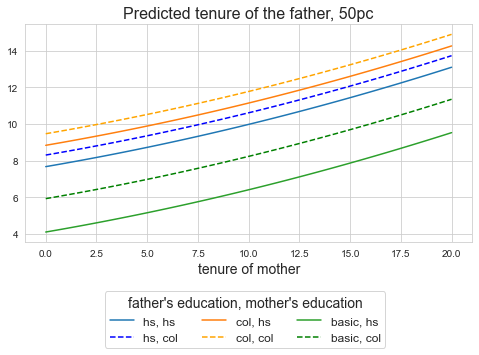

In [54]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(8,4))
plt.title('Predicted tenure of the father, 50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')

plt.xlabel('tenure of mother',fontsize=14)
plt.legend(title="father's education, mother's education",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.show()

In [100]:
path = './results/'

file_split('sqtreg_fathers_0k_45.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+'sqtreg_fathers_0k_45_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_50_0k = read_table(path+'sqtreg_fathers_0k_45_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_75_0k = read_table(path+'sqtreg_fathers_0k_45_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_d_45_0k = tab_dads_45_50_0k['Coefficient']
coef_25_d_45_0k = tab_dads_45_25_0k['Coefficient']
coef_75_d_45_0k = tab_dads_45_75_0k['Coefficient']


file_split('sqtreg_fathers_45.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+'sqtreg_fathers_45_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_50 = read_table(path+'sqtreg_fathers_45_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)
tab_dads_45_75 = read_table(path+'sqtreg_fathers_45_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,index_to_int=False)

coef_50_d_45 = tab_dads_45_50['Coefficient']
coef_25_d_45 = tab_dads_45_25['Coefficient']
coef_75_d_45 = tab_dads_45_75['Coefficient']

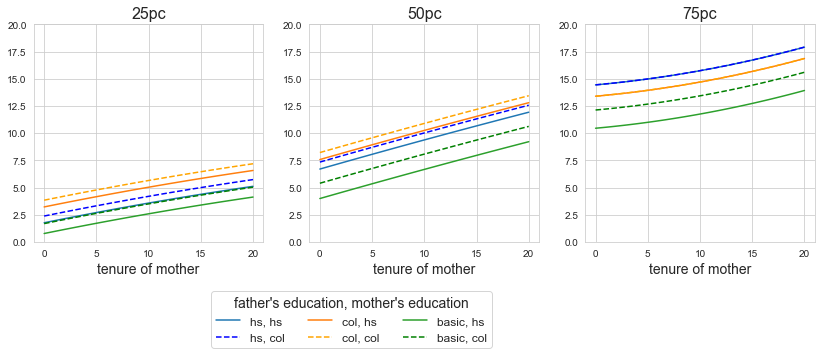

In [105]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
# plt.suptitle('Predicted tenure of the father, age 45 or less',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
plt.xlabel('tenure of mother',fontsize=14)
plt.legend(title="father's education, mother's education",fontsize=12,title_fontsize=14,
           ncol=3,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,20)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range),label='hs, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,hub_educ='college'),
         label='hs, col',c='blue',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college'),label='col, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),
         label='col, col',c='orange',ls='--')

plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='less_hs'),label='basic, hs')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='less_hs',hub_educ='college'),
         label='basic, col',c='g',ls='--')
# plt.axvline(descrip_stats['Tenure_father'][0]/12,ls='-.',lw=0.75,c='r')
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_all_dads_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

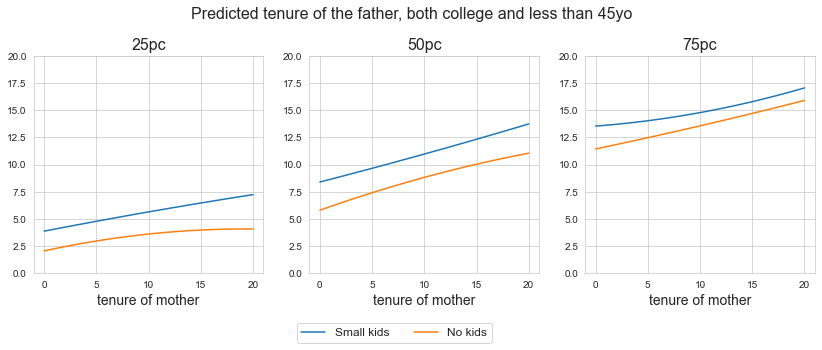

In [58]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_dads_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

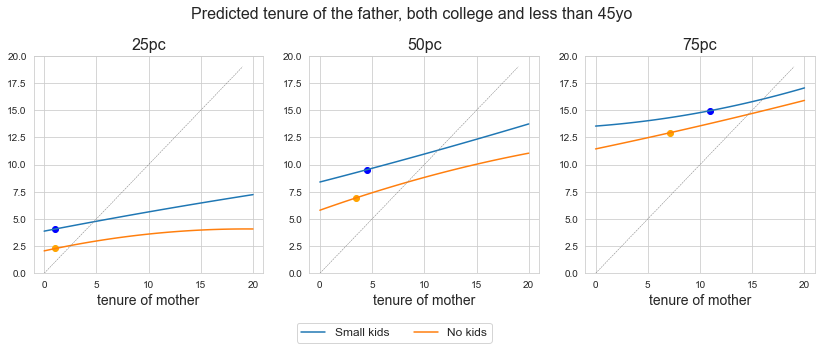

In [136]:
ten_range = np.linspace(0,20,100)
age_mean = descrip_stats['Age_father'][0]

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both college and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')

plt.scatter(mom_ten_25,predicted_ten_men(coef_25_d_45,descrip_stats,mom_ten_25,educ='college',hub_educ='college'),c='blue')
plt.scatter(wife_ten_25,predicted_ten_men(coef_25_d_45_0k,descrip_stats,wife_ten_25,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))

plt.scatter(mom_ten_50,predicted_ten_men(coef_50_d_45,descrip_stats,mom_ten_50,educ='college',hub_educ='college'),c='blue')
plt.scatter(wife_ten_50,predicted_ten_men(coef_50_d_45_0k,descrip_stats,wife_ten_50,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range,educ='college',hub_educ='college'),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range,educ='college',hub_educ='college'),label='No kids')

plt.scatter(mom_ten_75,predicted_ten_men(coef_75_d_45,descrip_stats,mom_ten_75,educ='college',hub_educ='college'),c='blue')
plt.scatter(wife_ten_75,predicted_ten_men(coef_75_d_45_0k,descrip_stats,wife_ten_75,educ='college',hub_educ='college'),c='orange')
plt.plot(range(20),range(20),ls="--",c='grey',lw=0.5)
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_college_dads_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

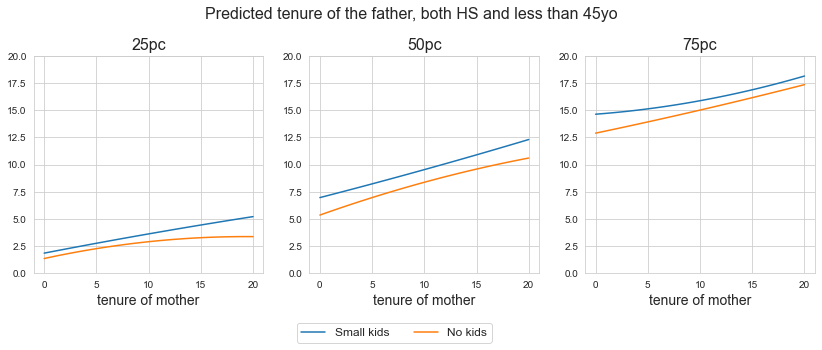

In [60]:
ten_range = np.linspace(0,20,100)

plt.figure(figsize=(14,4))
plt.suptitle('Predicted tenure of the father, both HS and less than 45yo',fontsize=16,y=1.05)
plt.subplot(131)
plt.title('25pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_25_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_25_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.xlabel('tenure of mother',fontsize=14)
plt.ylim(0,20)

plt.subplot(132)
plt.title('50pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_50_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_50_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.legend(fontsize=12,ncol=2,bbox_to_anchor=(0.82,-0.2))
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.subplot(133)
plt.title('75pc',fontsize=16)
plt.plot(ten_range,predicted_ten_men(coef_75_d_45,descrip_stats,ten_range),label='Small kids')
plt.plot(ten_range,predicted_ten_men(coef_75_d_45_0k,descrip_stats,ten_range),label='No kids')
plt.ylim(0,20)
plt.xlabel('tenure of mother',fontsize=14)

plt.savefig('./plots_tenure/qregs_spa_HS_dads_45.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [297]:
descrip_stats



,index,Tenure_mother,Tenure_father,Tenure_mother_PC,Tenure_father_PC,Participation_mother,Participation_father,Employment_mother,Employment_father,Unemployment_mother,Unemployment_father,Age_mother,Age_father,Hours_mother,Hours_father,dates
0,130,91.09012,116.9287,127.9036,141.4162,0.633599,0.961774,0.450439,0.709365,0.147943,0.044601,35.20958,37.41877,28.671940,38.063430,2005Q1
1,131,89.06780,115.4223,126.7102,143.1194,0.635941,0.963031,0.462568,0.724105,0.129352,0.036813,35.20274,37.49490,29.851419,40.176169,2005Q2
2,132,89.37599,114.5817,125.6732,140.4082,0.633274,0.960994,0.469644,0.723078,0.115090,0.038163,35.21030,37.48182,28.971241,38.834750,2005Q3
3,133,90.05831,114.4557,129.0288,141.2429,0.649908,0.961877,0.478113,0.719393,0.125371,0.037142,35.22358,37.49816,29.290787,39.165262,2005Q4
4,134,91.16219,116.4211,130.2905,146.4587,0.659418,0.962015,0.483887,0.715218,0.130488,0.039579,35.29366,37.62405,29.797640,39.625940,2006Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,193,111.58080,125.1961,139.5246,146.7777,0.812523,0.954835,0.587577,0.705015,0.180266,0.078425,38.19639,40.31597,29.603744,36.326162,2020Q4
64,194,116.03410,131.8757,139.5533,149.7803,0.814278,0.949276,0.588652,0.699881,0.176658,0.080463,38.55468,40.47890,27.780260,34.619440,2021Q1
65,195,113.27630,128.4572,138.7459,146.1301,0.821331,0.957396,0.599467,0.712823,0.164208,0.070140,38.59576,40.54585,31.130821,38.005726,2021Q2
66,196,112.86080,128.3862,139.8803,146.5570,0.817427,0.959945,0.605297,0.714653,0.152793,0.077505,38.72406,40.67633,28.817812,34.794831,2021Q3
